___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://timelyportfolio.github.io/rCharts_time_series/assets/fig/unnamed-chunk-14.png" width="350px" height="180px" />


# <font color= #8A0829> Laboratorio de Modelado de Datos </font>
- <Strong> Ana Rosaura Zamarrón Álvarez </Strong>
- <Strong> Año </Strong>: 2021
- <Strong> Email: </Strong>  <font color="blue"> `ana.zamarron@iteso.mx` </font>
___

<p style="text-align:right;"> Imagen recuperada de: https://timelyportfolio.github.io/rCharts_time_series/assets/fig/unnamed-chunk-14.png</p>

### <font color= #2E9AFE> Tema: Series de Tiempo con Clustering</font>

Objetivo: aprender sobre acciones de la bolsa utilizando algoritmos de clustering para agrupar acciones que tienen un comportamiento similar. 

Vamos a enfocarnos en acciones que son parte del índice del Dow Jones. También en algunas del índice del S&P500

Tanto el Dow Jones, como el S&P 500 son índices bursátiles del mercado estadounidense.

Estos índices se calculan a partir de la cotizaciones de las empresas que se agrupan en ellos. 

El **Dow Jones** agrupa a las 30 mayores empresas cotizadas de EE.UU., mientras que el **S&P 500** engloba las 500 empresas más representativas de la Bolsa de Nueva York. 

**Dow Jones**
El Dow Jones Industrial Average (DJIA) fue creado por Charles Dow - uno de los fundadores de la empresa Dow Jones & Co., firma que también creó el diario The Wall Street Journal — y se ha publicado desde 1896, lo que le convierte en el indicador bursátil más antiguo del país.

El Dow Jones aglutina las 30 mayores empresas cotizadas de Estados Unidos proveniente de los distintos sectores de la Industria excepto de transporte y energía que se miden en índices separados.

**S&P 500**
Se suelte considerar por los analistas como el indicador más próximo a la situación real en la que se encuentra el mercado.

Bajo este índice se agrupan las 500 mayores compañías estadounidenses que cotizan en bolsa, concretamente en la bolsa de Nueva York. Debido a este alto volumen de compañías representadas es un indicador más grande y diverso que el Dow Jones.

Las acciones en el S&P 500 representan aproximadamente el 80%  del valor total de los mercados bursátiles de EE.UU. y provienen de todos los sectores de la economía.

Estas compañías no son fijas, son seleccionadas por un comité de la firma S&P, propiedad de McGraw Hill Financial y deben cumplir una serie de requisitos para poder ser incluidas en dicho índice, relacionados con su capitalización bursátil, liquidez, capital flotante, viabilidad financiera, antigüedad en bolsa y su negociación en la bolsa de valores.

### Datos

Vamos a utilizar varias fuentes de datos:
- Lista de compañías que son parte del índice del Dow Jones: https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average
- Datos de los últimos 5 años del índice del S&P500
- Alguna información sobre los componentes de las acciones del S&P500, principalmente el símbolo de cada compañía

#### S&P500

Se tienen datos de acciones de cada compañía que es parte del índice, etiquetadas por su nombre de cotización en la bolsa. 

- Date: en formato yy-mm-dd
- Open: precio de la acción cuando el mercado abre (USD)
- Low Close: precio más bajo alcanzado durante el día
- Volume: número de acciones negociadas
- Name: nombre de la acción en la bolsa


In [4]:
#pip install wikitables

In [3]:
#librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from wikitables import import_tables 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

random.seed(42)
plt.rcParams['figure.figsize'] = (7,4.5) 

In [6]:
#Cargar datos
data = pd.read_csv('all_stocks_5yr.csv')
data = data.rename(columns={'Name':'symbol'})
data['date'] = pd.to_datetime(data['date'])
data.head()

date   open   high    low  close    volume symbol
0 2013-02-08  15.07  15.12  14.63  14.75   8407500    AAL
1 2013-02-11  14.89  15.01  14.26  14.46   8882000    AAL
2 2013-02-12  14.45  14.51  14.10  14.27   8126000    AAL
3 2013-02-13  14.30  14.94  14.25  14.66  10259500    AAL
4 2013-02-14  14.94  14.96  13.16  13.99  31879900    AAL

#### Lista de las compañías del S&P500

Las descargamos de aquí:
https://en.wikipedia.org/wiki/List_of_S%26P_500_companies

In [8]:
companies = pd.read_csv('/Users/rosaura/Downloads/companies.csv')
companies = companies.set_index(['symbol'])
companies.head()

security                  sector  \
symbol                                                     
A       Agilent Technologies Inc             Health Care   
AAL      American Airlines Group             Industrials   
AAP           Advance Auto Parts  Consumer Discretionary   
AAPL                  Apple Inc.  Information Technology   
ABBV                 AbbVie Inc.             Health Care   

                                      sub-industry  
symbol                                              
A                            Health Care Equipment  
AAL                                       Airlines  
AAP                              Automotive Retail  
AAPL    Technology Hardware, Storage & Peripherals  
ABBV                               Pharmaceuticals

#### Lista de las compañías del Dow Jones

Las podemos descargar de aquí:
https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average

In [9]:
try:
    dow = pd.read_csv('/Users/rosaura/Downloads/dow.csv')
    print('datos cargados del archivo')
except FileNotFoundError:
    print('Obteniendo las compañías del dow jones de wikipedia ...')
    tables = import_tables('Dow_Jones_Industrial_Average')
    dow = pd.read_json(tables[0].json())
    for c in dow.columns:
        if type(dow[c].iloc[0]) is str:
            dow[c] = dow[c].str.strip().str.replace('\t','')
    dow = dow[['Symbol', 'Company']]
    dow.columns = [c.lower() for c in dow.columns]
    dow = dow.sort_values('symbol')
    dow = dow.set_index('symbol')
    dow.to_csv('/Users/rosaura/Downloads/dow.csv', index_label=False)
    print('Archivo descargado')

datos cargados del archivo


In [11]:
dow.head()

company
AAPL             Apple
AMGN             Amgen
AXP   American Express
BA              Boeing
CAT        Caterpillar

#### Preparar datos

In [12]:
#seleccionar sólo la fecha, el precio de cierre y el simbolo de la compañía
data = data[['date', 'close', 'symbol']]
data.head()

date  close symbol
0 2013-02-08  14.75    AAL
1 2013-02-11  14.46    AAL
2 2013-02-12  14.27    AAL
3 2013-02-13  14.66    AAL
4 2013-02-14  13.99    AAL

In [13]:
#hacer un pivote para que ahora cada empresa esté en cada columna 
acciones = data.pivot(index='date', columns='symbol', values='close')
acciones = acciones.dropna(axis=1)
acciones.head()

symbol          A    AAL    AAP     AAPL   ABBV    ABC    ABT    ACN   ADBE  \
date                                                                          
2013-02-08  45.08  14.75  78.90  67.8542  36.25  46.89  34.41  73.31  39.12   
2013-02-11  44.60  14.46  78.39  68.5614  35.85  46.76  34.26  73.07  38.64   
2013-02-12  44.62  14.27  78.60  66.8428  35.42  46.96  34.30  73.37  38.89   
2013-02-13  44.75  14.66  78.97  66.7156  35.27  46.64  34.46  73.56  38.81   
2013-02-14  44.58  13.99  78.84  66.6556  36.57  46.77  34.70  73.13  38.61   

symbol        ADI  ...     XL   XLNX    XOM   XRAY    XRX    XYL    YUM  \
date               ...                                                    
2013-02-08  45.70  ...  28.24  37.51  88.61  42.87  31.84  27.09  65.30   
2013-02-11  46.08  ...  28.31  37.46  88.28  42.84  31.96  27.46  64.55   
2013-02-12  46.27  ...  28.41  37.58  88.46  42.87  31.84  27.95  64.75   
2013-02-13  46.26  ...  28.42  37.80  88.67  43.08  32.00  28.26  64.41   
2013-02-14  46.54  ...  28.22  38.44  88.52  42.91  32.12  28.47  63.89   

symbol        ZBH   ZION    ZTS  
date                             
2013-02-08  75.85  24.14  33.05  
2013-02-11  75.65  24.21  33.26  
2013-02-12  75.44  24.49  33.74  
2013-02-13  76.00  24.74  33.55  
2013-02-14  76.34  24.63  33.27  

[5 rows x 470 columns]

In [14]:
#Hacer que los datos sean semanales en lugar de diarios
acciones = acciones.resample('W').last() #se queda con el últimpo precio de cada semana
acciones.head()

symbol          A    AAL    AAP     AAPL   ABBV    ABC    ABT    ACN    ADBE  \
date                                                                           
2013-02-10  45.08  14.75  78.90  67.8542  36.25  46.89  34.41  73.31  39.120   
2013-02-17  42.25  14.50  79.00  65.7371  37.58  46.60  35.08  74.16  38.635   
2013-02-24  41.80  13.57  79.21  64.4014  38.46  46.95  34.55  74.80  38.550   
2013-03-03  41.93  13.61  76.37  61.4957  37.81  47.98  33.60  74.82  39.830   
2013-03-10  43.03  14.92  76.84  61.6742  37.34  48.48  34.68  78.35  41.500   

symbol         ADI  ...     XL   XLNX    XOM   XRAY    XRX    XYL    YUM  \
date                ...                                                    
2013-02-10  45.700  ...  28.24  37.51  88.61  42.87  31.84  27.09  65.30   
2013-02-17  46.175  ...  28.67  38.12  88.36  42.80  31.88  28.28  63.99   
2013-02-24  45.520  ...  28.99  37.96  89.20  41.78  32.48  27.79  65.45   
2013-03-03  45.230  ...  28.82  36.65  89.43  41.16  32.60  27.49  65.21   
2013-03-10  46.050  ...  29.66  38.37  88.97  42.74  34.84  28.43  67.72   

symbol        ZBH   ZION    ZTS  
date                             
2013-02-10  75.85  24.14  33.05  
2013-02-17  75.90  24.34  33.98  
2013-02-24  74.14  24.04  32.59  
2013-03-03  74.99  24.04  34.60  
2013-03-10  75.40  25.30  34.09  

[5 rows x 470 columns]

#### Análisis Exploratorio

In [15]:
#Función para extraer el símbolo de la acción
def get_name(symbol):
    name = symbol
    try:
        name = companies.loc[symbol]['security']
    except KeyError:
        pass
    return name

#Función para graficar la acción
def plot_stock(symbol, stocks=acciones):
    name = get_name(symbol)
    stocks[symbol].plot(title=name, label=name, alpha=0.9);

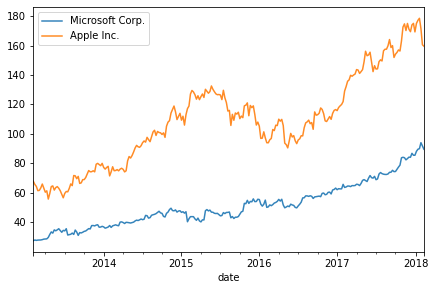

In [16]:
plot_stock('MSFT')
plot_stock('AAPL')
plt.title('')
plt.legend()

#### Calcular los rendimientos para poder comparar las acciones

In [17]:
#Rendimientos
start = acciones.iloc[0]
rendimientos = (acciones - start) / start

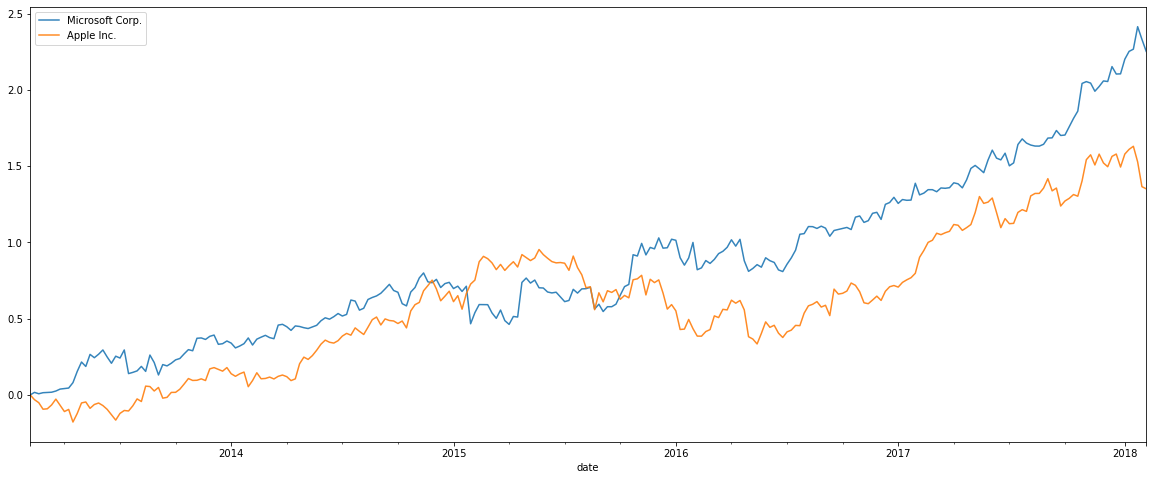

In [18]:
#Graficar rendimientos
plt.figure(figsize = (20,8))
plot_stock('MSFT', stocks=rendimientos)
plot_stock('AAPL', stocks=rendimientos)
plt.title('')
plt.legend();

#### ¿Cuáles son las mejores y peores acciones de los últimos 5 años?

In [19]:
mejores = rendimientos.iloc[-1].sort_values(ascending=False).head()
peores = rendimientos.iloc[-1].sort_values().head()

In [20]:
print('Mejores acciones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in mejores.index.tolist()]}, index = mejores.index)
mejores = pd.concat((mejores, names), axis=1)
mejores

Mejores acciones


2018-02-11 00:00:00                  name
symbol                                           
NVDA              17.496362    Nvidia Corporation
NFLX               9.233321          Netflix Inc.
ALGN               6.159487      Align Technology
EA                 6.084053       Electronic Arts
STZ                5.723705  Constellation Brands

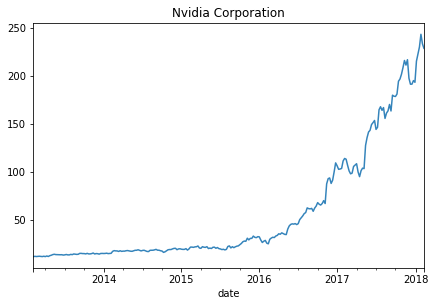

In [21]:
plot_stock('NVDA')

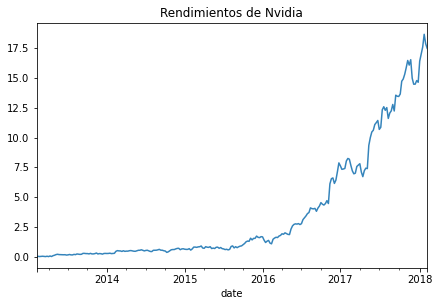

In [22]:
plot_stock('NVDA', stocks=rendimientos)
plt.title('Rendimientos de Nvidia');

In [23]:
print('Peores acciones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in peores.index.tolist()]}, index = peores.index)
peores = pd.concat((peores, names), axis=1)
peores

Peores acciones


2018-02-11 00:00:00                    name
symbol                                             
CHK               -0.857143                     CHK
RRC               -0.818157   Range Resources Corp.
DISCA             -0.676508  Discovery Inc. Class A
DISCK             -0.660217  Discovery Inc. Class C
MOS               -0.588762      The Mosaic Company

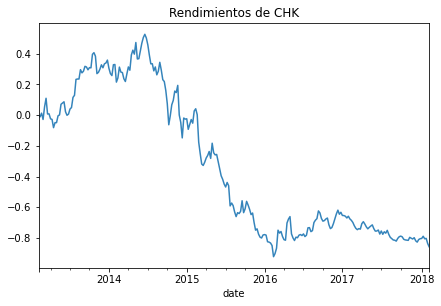

In [24]:
plot_stock('CHK', stocks=rendimientos)
plt.title('Rendimientos de CHK');

#### Enfocándonos en las acciones del Dow Jones

In [25]:
dow_acciones = [s for s in dow.index if s in acciones.columns]
dow_rendimientos = rendimientos[dow_acciones]

In [26]:
print(dow_acciones)

['AAPL', 'AMGN', 'AXP', 'BA', 'CAT', 'CRM', 'CSCO', 'CVX', 'DIS', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'V', 'VZ', 'WBA', 'WMT']


In [27]:
mejores_dow = dow_rendimientos.iloc[-1].sort_values(ascending=False).head()
peores_dow = dow_rendimientos.iloc[-1].sort_values().head()
print('Mejores acciones del Dow Jones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in mejores_dow.index.tolist()]}, index = mejores_dow.index)
mejores_dow = pd.concat((mejores_dow, names), axis=1)
mejores_dow

Mejores acciones del Dow Jones


2018-02-11 00:00:00                      name
symbol                                               
BA                 3.547022            Boeing Company
UNH                2.910980  United Health Group Inc.
MSFT               2.252632           Microsoft Corp.
V                  2.032953                 Visa Inc.
HD                 1.854649                Home Depot

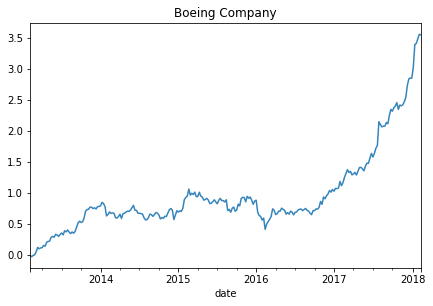

In [28]:
plot_stock('BA', stocks=rendimientos);

In [29]:
print('Peores acciones del Dow Jones')
names = pd.DataFrame({'name':[get_name(symbol) for symbol in peores_dow.index.tolist()]}, index = peores_dow.index)
peores_dow = pd.concat((peores_dow, names), axis=1)
peores_dow

Peores acciones del Dow Jones


2018-02-11 00:00:00                             name
symbol                                                      
IBM               -0.237158  International Business Machines
CVX               -0.003027                    Chevron Corp.
PG                 0.080396                 Procter & Gamble
KO                 0.149342          Coca-Cola Company (The)
VZ                 0.150169           Verizon Communications

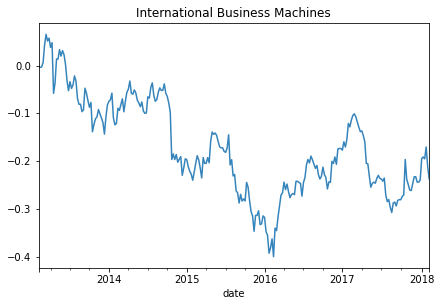

In [30]:
plot_stock('IBM', stocks=rendimientos);

#### Clustering

In [31]:
dow_rendimientos.head()

symbol          AAPL      AMGN       AXP        BA       CAT       CRM  \
date                                                                     
2013-02-10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2013-02-17 -0.031201 -0.036418 -0.001780 -0.019984 -0.012803  0.029891   
2013-02-24 -0.050886  0.000576  0.012460  0.001306 -0.054827  0.003589   
2013-03-03 -0.093708  0.066959  0.009223  0.009404 -0.056686  0.070903   
2013-03-10 -0.091078  0.071799  0.046926  0.060998 -0.065462  0.093557   

symbol          CSCO       CVX       DIS        GS  ...       MRK      MSFT  \
date                                                ...                       
2013-02-10  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
2013-02-17 -0.008034 -0.005880  0.017380  0.022361  ...  0.005828  0.016697   
2013-02-24 -0.012287  0.002767 -0.007501  0.016425  ...  0.043468  0.007623   
2013-03-03 -0.015595  0.010896  0.012258 -0.007058  ...  0.035211  0.014519   
2013-03-10  0.031664  0.025337  0.049945  0.009103  ...  0.043468  0.016334   

symbol           NKE        PG       TRV       UNH         V        VZ  \
date                                                                     
2013-02-10  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2013-02-17  0.006595  0.010429  0.019401 -0.007274  0.001204  0.001127   
2013-02-24 -0.002198  0.016370  0.027264 -0.056633  0.010330  0.023675   
2013-03-03  0.004213  0.009769  0.023206 -0.073086  0.001774  0.053439   
2013-03-10  0.001832  0.018878  0.035379 -0.068064  0.018188  0.081398   

symbol           WBA       WMT  
date                            
2013-02-10  0.000000  0.000000  
2013-02-17 -0.006039 -0.030498  
2013-02-24  0.009903 -0.015109  
2013-03-03 -0.001932  0.003637  
2013-03-10 -0.018357  0.021684  

[5 rows x 29 columns]

In [32]:
dow_rendimientos.shape

(262, 29)

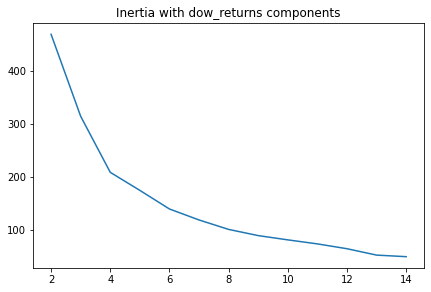

In [33]:
#gráfica de codo para encontrar el k optimo
inertias = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(dow_rendimientos.T)
    inertias.append(kmeans.inertia_)
plt.plot(range(2,15), inertias)
plt.title('Inertia with dow_returns components');

In [34]:
from kneed import KneeLocator
kl = KneeLocator(
     range(2, 15), inertias, curve="convex", direction="decreasing")

kl.elbow

6

In [35]:
#Aplicar el kmeans
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(dow_rendimientos.T);

clusters = {}
for l in np.unique(kmeans.labels_):
    clusters[l] = []

#Asignar cada dato a un cluster
for i,l in enumerate(kmeans.predict(dow_rendimientos.T)):
    clusters[l].append(dow_rendimientos.columns[i])

    #Que imprima los clusters    
for c in sorted(clusters):
    print('Cluster ' + str(c) + ': ', end='')
    for symbol in clusters[c]:
        print(get_name(symbol) + ' (' + symbol + ')', end=' ### ')
    print()
    print()

Cluster 0: Caterpillar Inc. (CAT) ### Chevron Corp. (CVX) ### International Business Machines (IBM) ### Coca-Cola Company (The) (KO) ### Procter & Gamble (PG) ### Verizon Communications (VZ) ### Wal-Mart Stores (WMT) ### 

Cluster 1: Apple Inc. (AAPL) ### Salesforce.com (CRM) ### Honeywell Int'l Inc. (HON) ### Intel Corp. (INTC) ### 3M Company (MMM) ### 

Cluster 2: Boeing Company (BA) ### United Health Group Inc. (UNH) ### 

Cluster 3: Home Depot (HD) ### Microsoft Corp. (MSFT) ### Visa Inc. (V) ### 

Cluster 4: Amgen Inc. (AMGN) ### The Walt Disney Company (DIS) ### Nike (NKE) ### Walgreens Boots Alliance (WBA) ### 

Cluster 5: American Express Co (AXP) ### Cisco Systems (CSCO) ### Goldman Sachs Group (GS) ### Johnson & Johnson (JNJ) ### JPMorgan Chase & Co. (JPM) ### McDonald's Corp. (MCD) ### Merck & Co. (MRK) ### The Travelers Companies Inc. (TRV) ### 



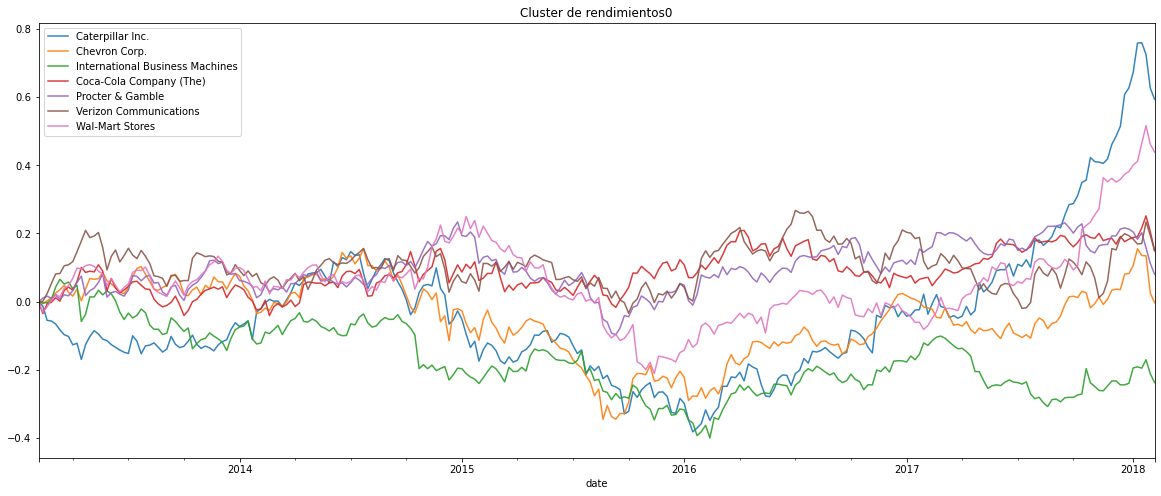

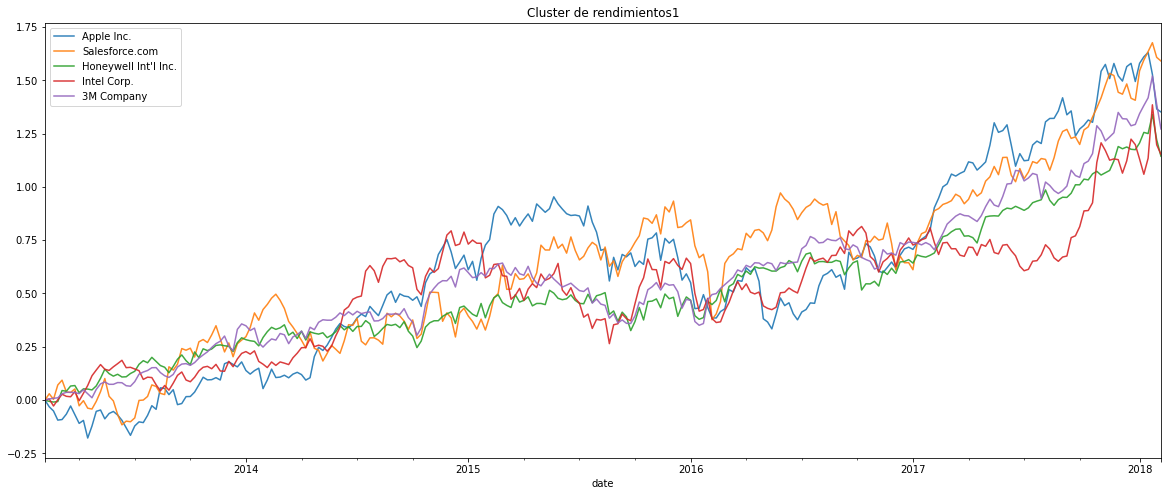

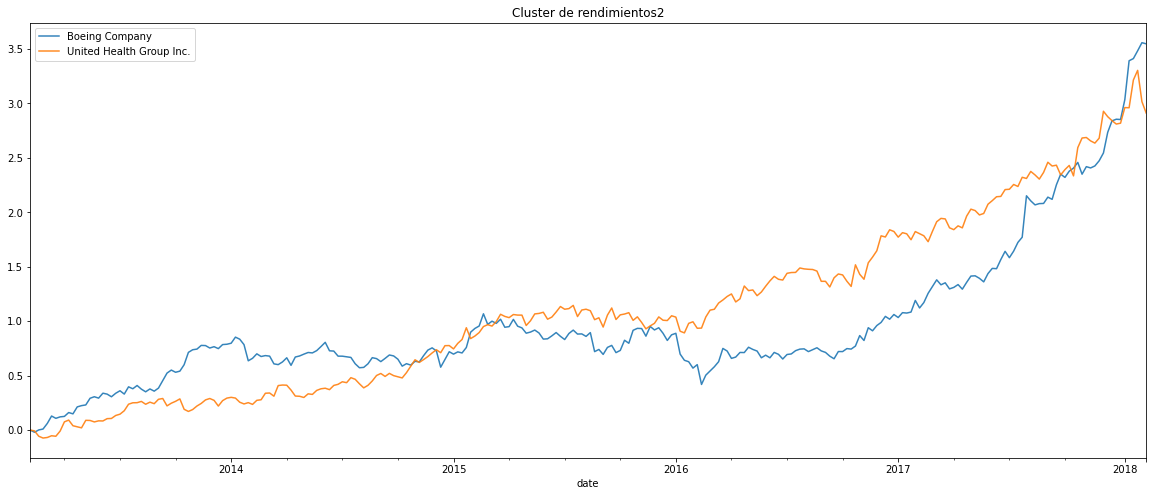

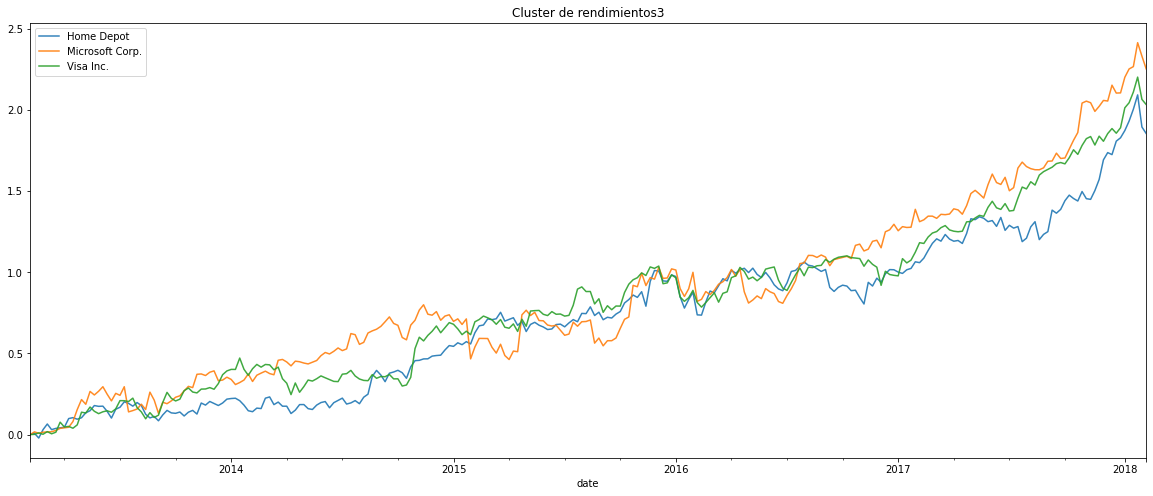

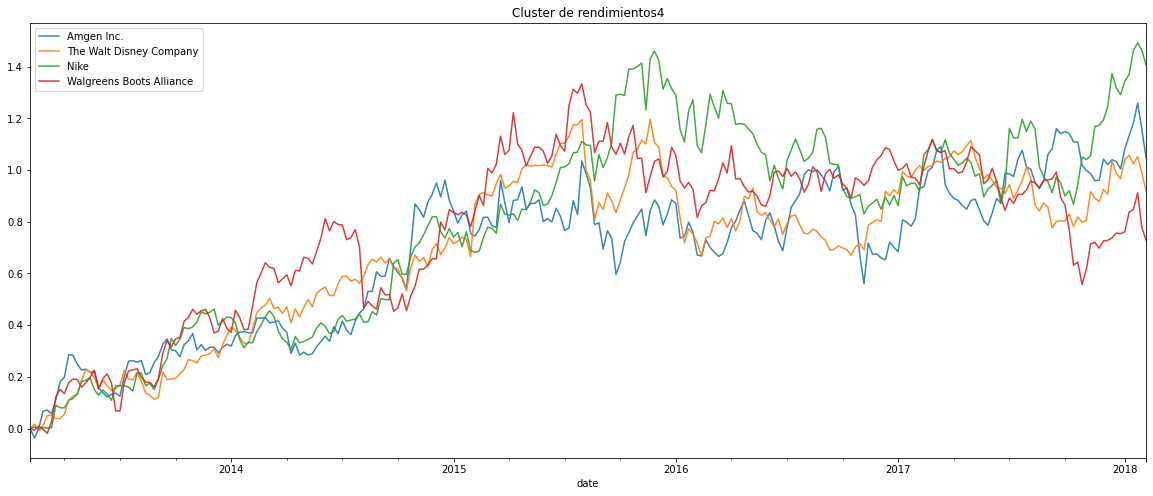

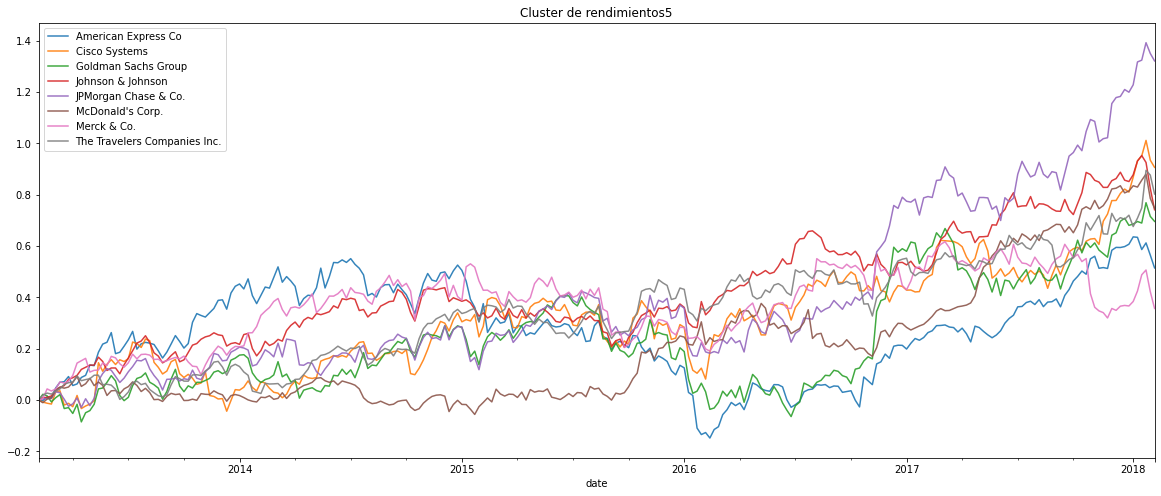

In [36]:
#Graficar todos los clusters
for c in sorted(clusters):
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=dow_rendimientos)
    plt.title('Cluster de rendimientos' + str(c))
    plt.legend()
    plt.show()

#### Análisis de Componentes Principales

Es una práctica común aplicar el PCA (análisis de componentes principales) antes de un algoritmo de clustering (como Kmeans). Se cree que mejora los resultados del clustering en la práctica (ya que ayuda a la reducción del ruido).

Mantengamos al menos el 95% de la varianza

In [37]:
#Hacer el PCA
pca = PCA(n_components=.95, random_state=1)
components = pca.fit_transform(dow_rendimientos.T)
print('Numero de componentes principales', components.shape[1])
print('Razón de varianza explicada por PCA:', pca.explained_variance_ratio_)
print('Varianza explicada total de PCA: ', np.sum(pca.explained_variance_ratio_))

Numero de componentes principales 3
Razón de varianza explicada por PCA: [0.86199615 0.07609456 0.02375571]
Varianza explicada total de PCA:  0.9618464220087027


Vamos a ver qué tan bien podemos capturar los rendimientos de las acciones. 

Utilizaremos la función de PCA.inverse_transform para ir desde los componentes del PCA hasta los rendimientos. Después vamos a graficar los rendimientos originales y los componentes del PCA recuperados. 

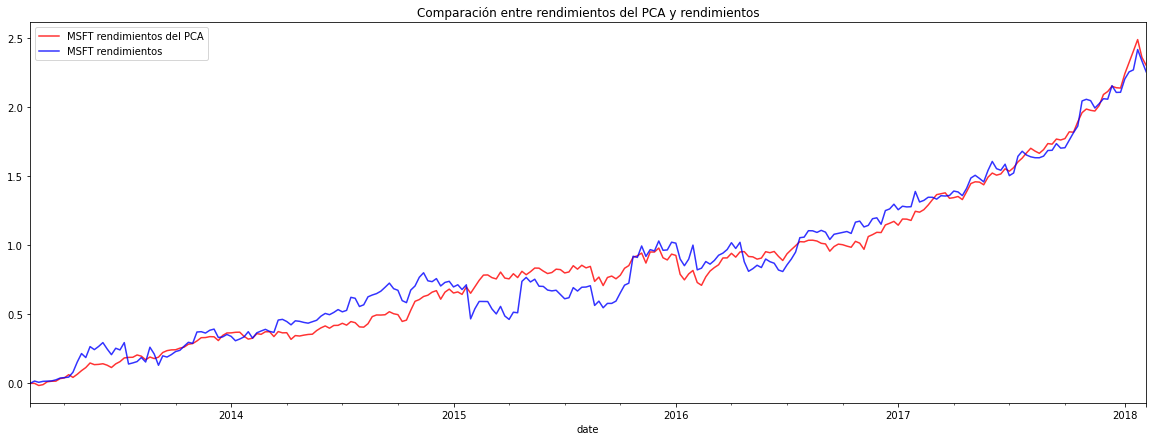

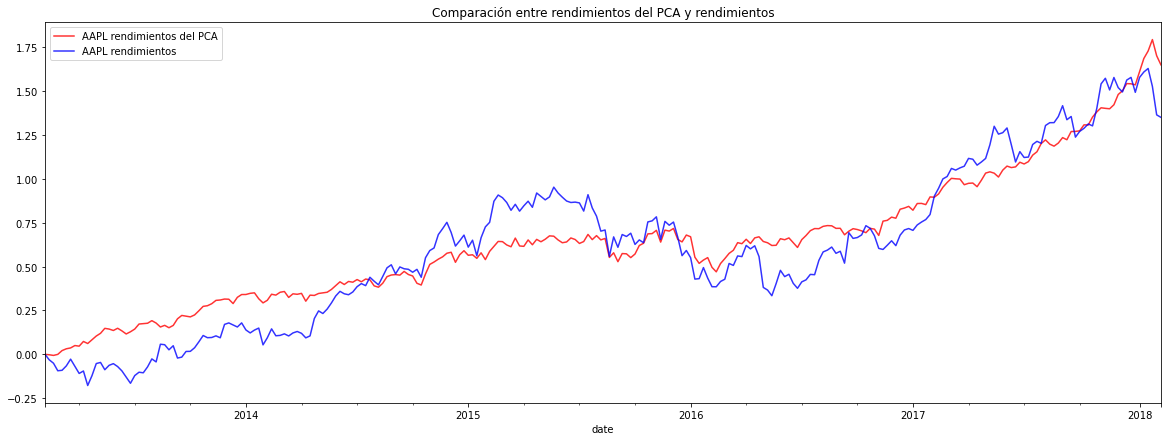

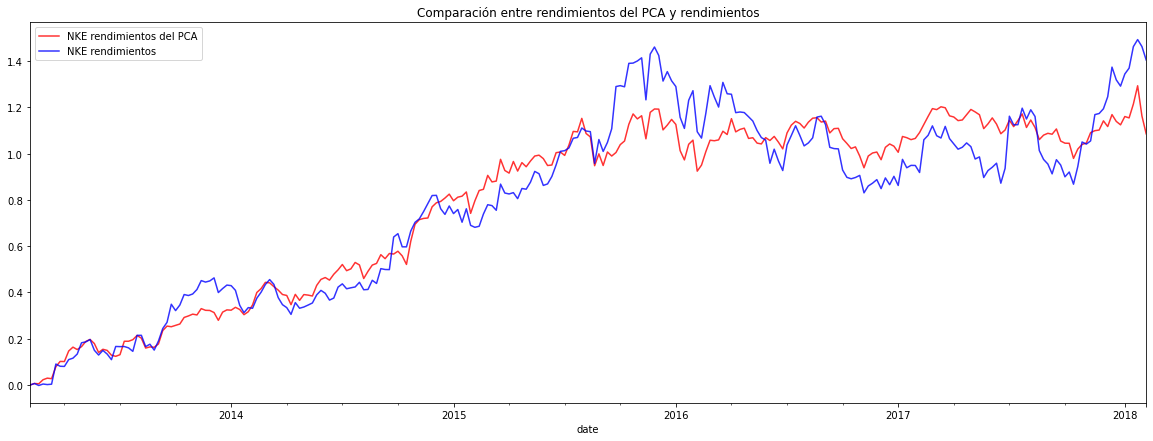

In [38]:
for stock in ['MSFT', 'AAPL', 'NKE']:
    pos_stock = dow_rendimientos.columns.tolist().index(stock)
    stock_from_pca = pca.inverse_transform(components[pos_stock,:])
    stock_from_pca = pd.Series(stock_from_pca, name=stock, index=dow_rendimientos.index)
    plt.figure(figsize=(20,7))
    stock_from_pca.plot(label = stock + ' rendimientos del PCA', color='red', alpha=0.8)
    dow_rendimientos[stock].plot(label = stock + ' rendimientos', color='blue', alpha=0.8)
    plt.title('Comparación entre rendimientos del PCA y rendimientos')
    plt.legend()
    plt.show();

#### Visualizar los primeros 2 componentes principales

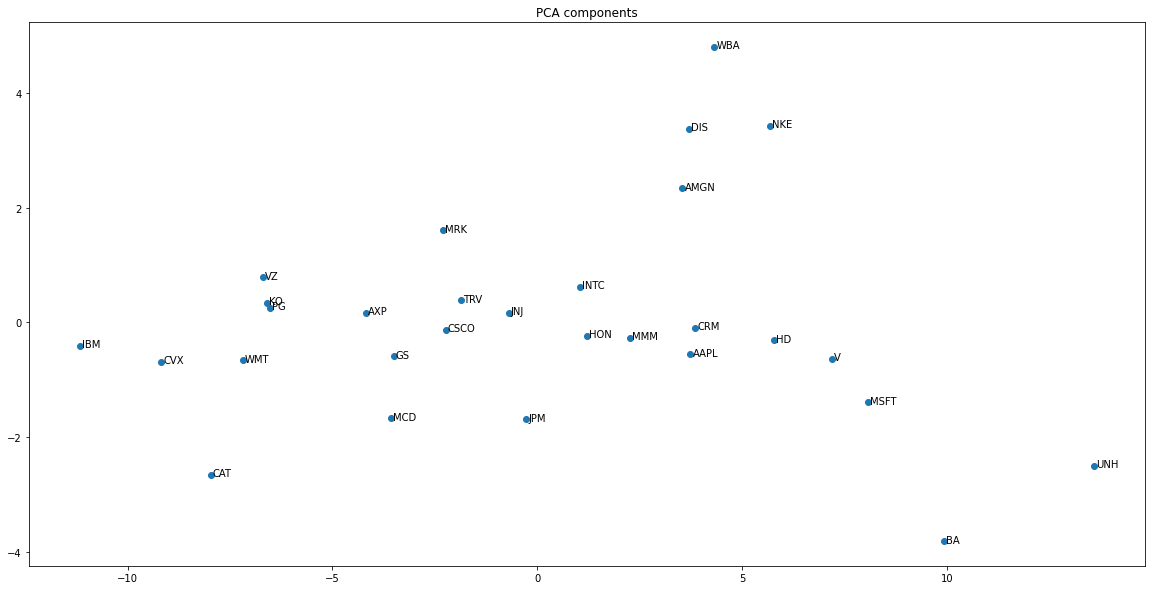

In [39]:
plt.figure(figsize=(20,10))
plt.scatter(components[:,0], components[:,1])
for i in range(components.shape[0]):
    plt.text(x=components[i,0]+0.05, y=components[i,1]-0.025, s=dow_rendimientos.columns[i])
plt.title('PCA components');

#### Utilizar el logaritmo del rendimiento  para colorear los datos y darnos una idea de qué está haciendo el PCA

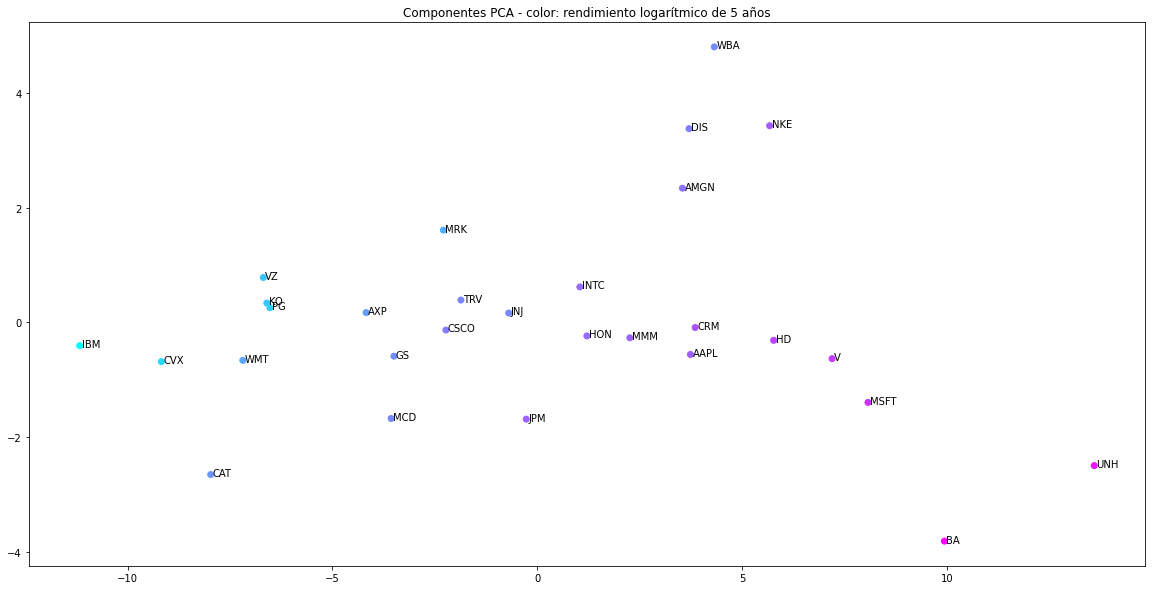

In [40]:
plt.figure(figsize=(20,10))
plt.scatter(components[:,0], components[:,1],  c = dow_rendimientos.iloc[-1].T.apply(np.log1p), cmap='cool')
for i in range(components.shape[0]):
    symbol = dow_rendimientos.columns[i]
    plt.text(x=components[i,0]+0.05, y=components[i,1]-0.025, s=symbol,)
plt.title('Componentes PCA - color: rendimiento logarítmico de 5 años');

#### Clustering con PCA

In [41]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(components);

clusters = {}
for l in np.unique(kmeans.labels_):
    clusters[l] = []

for i,l in enumerate(kmeans.predict(components)):
    clusters[l].append(dow_rendimientos.columns[i])
    
for c in clusters:
    print('Cluster ' + str(c) + ': ', end='')
    for symbol in clusters[c]:
        print(get_name(symbol) + ' (' + symbol + ')', end=' ### ')
    print()
    print()

Cluster 0: Apple Inc. (AAPL) ### Salesforce.com (CRM) ### Home Depot (HD) ### Honeywell Int'l Inc. (HON) ### Intel Corp. (INTC) ### 3M Company (MMM) ### 

Cluster 1: Caterpillar Inc. (CAT) ### Chevron Corp. (CVX) ### International Business Machines (IBM) ### Coca-Cola Company (The) (KO) ### Procter & Gamble (PG) ### Verizon Communications (VZ) ### Wal-Mart Stores (WMT) ### 

Cluster 2: Boeing Company (BA) ### Microsoft Corp. (MSFT) ### United Health Group Inc. (UNH) ### Visa Inc. (V) ### 

Cluster 3: American Express Co (AXP) ### Cisco Systems (CSCO) ### Goldman Sachs Group (GS) ### Johnson & Johnson (JNJ) ### JPMorgan Chase & Co. (JPM) ### McDonald's Corp. (MCD) ### Merck & Co. (MRK) ### The Travelers Companies Inc. (TRV) ### 

Cluster 4: Amgen Inc. (AMGN) ### The Walt Disney Company (DIS) ### Nike (NKE) ### Walgreens Boots Alliance (WBA) ### 



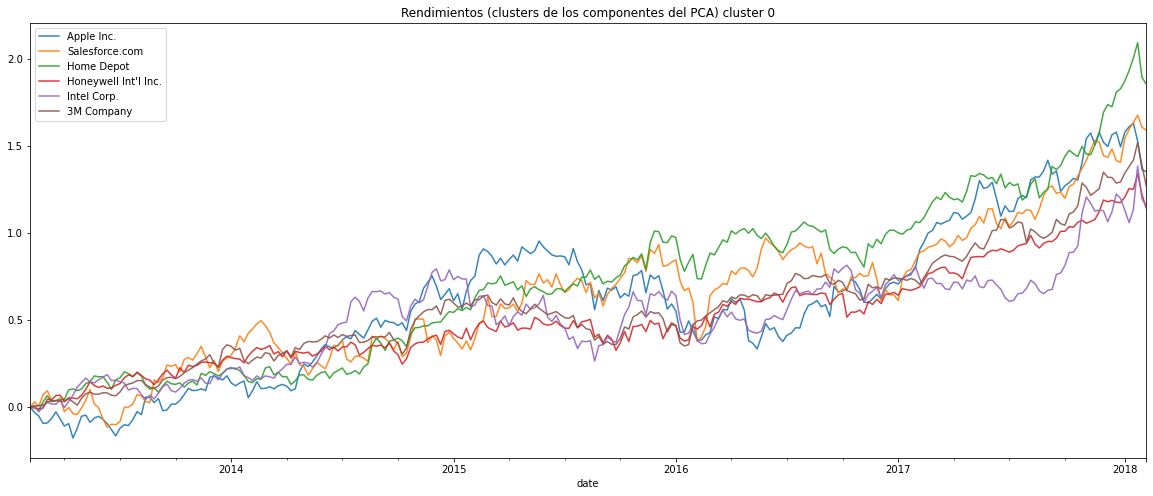

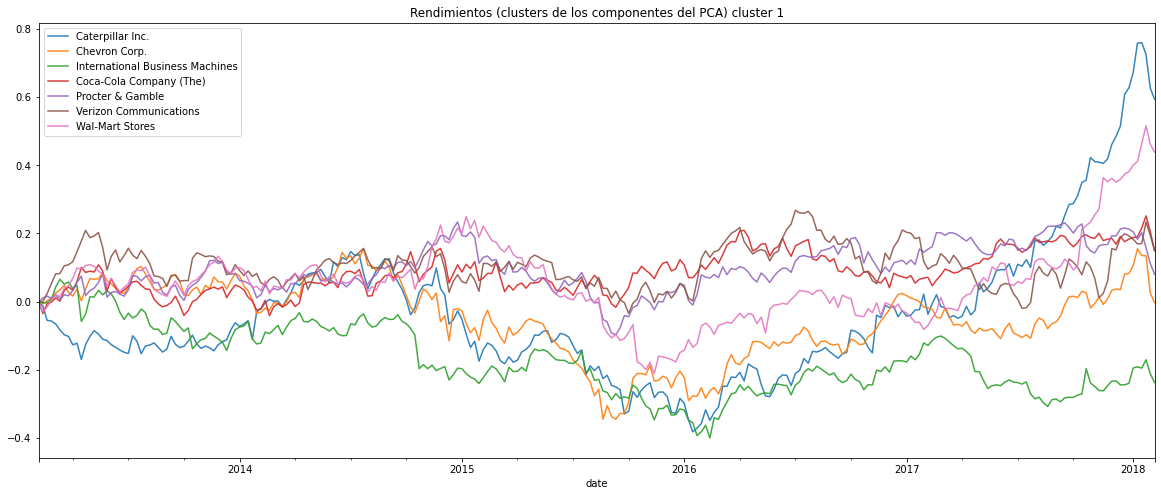

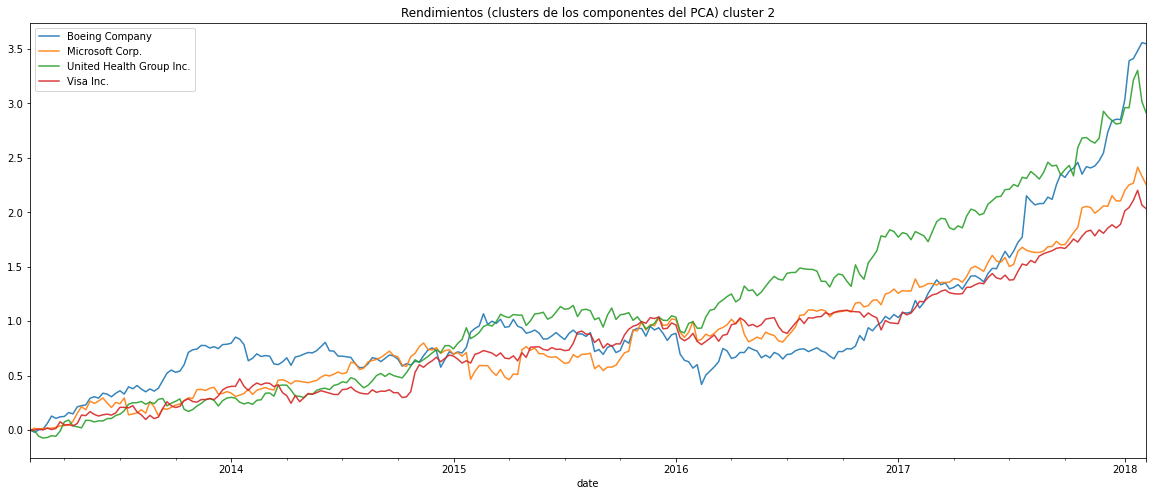

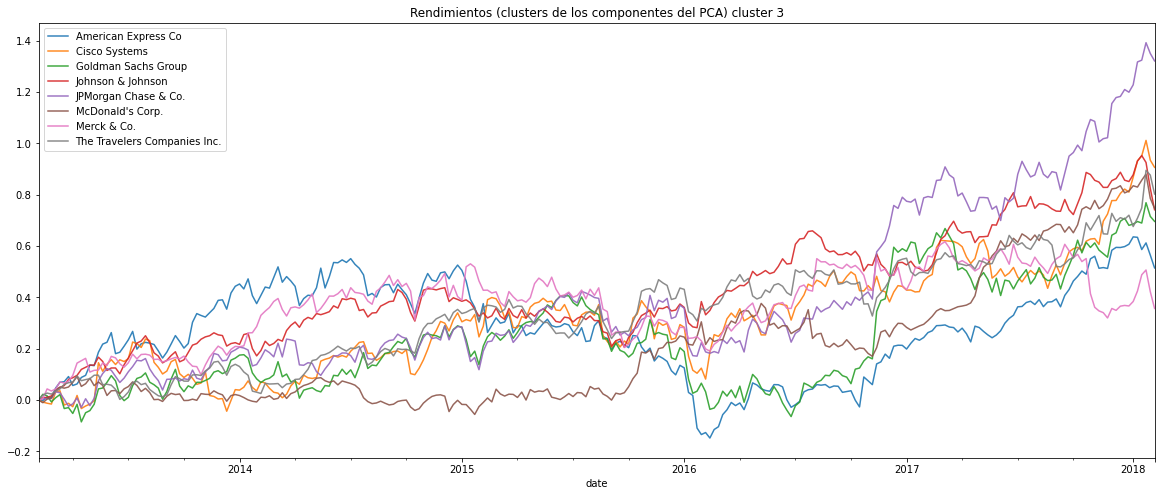

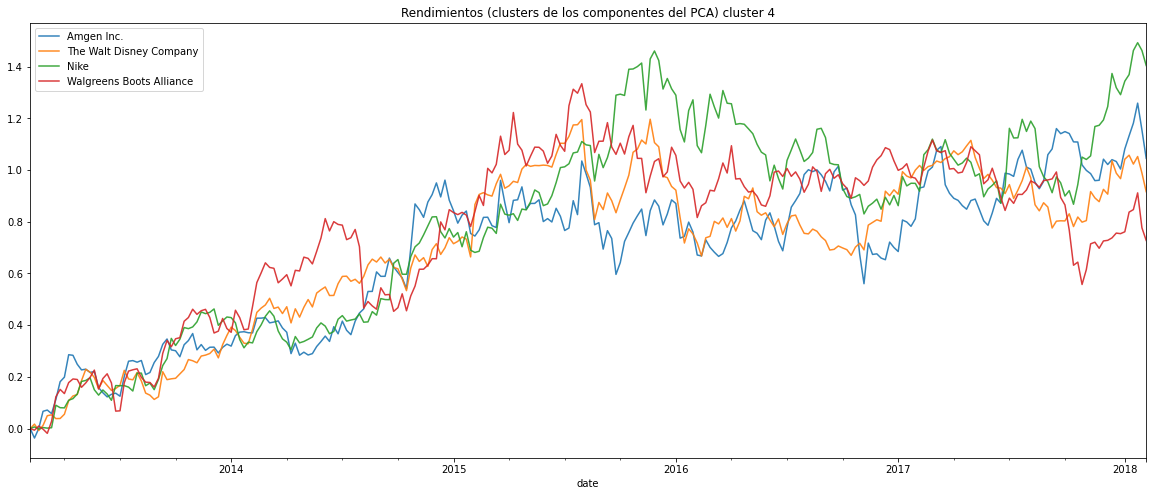

In [42]:
for c in sorted(clusters):
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=dow_rendimientos)
    plt.title('Rendimientos (clusters de los componentes del PCA) cluster ' + str(c))
    plt.legend()
    plt.show()

#### Analizar el comportamiento de las acciones  

- Analizar el rendimiento a la mitad del periodo (2 años y medio)
- Analizar el rendimiento al final del periodo (5 años)

In [43]:
mitad = len(dow_rendimientos) // 2
mit_final = dow_rendimientos.iloc[[mitad, -1]]
mit_final

symbol          AAPL      AMGN       AXP        BA       CAT       CRM  \
date                                                                     
2015-08-16  0.708958  0.932926  0.309223  0.895115 -0.189572  0.717917   
2018-02-11  1.351218  1.045292  0.514725  3.547022  0.593598  1.590174   

symbol          CSCO       CVX       DIS        GS  ...       MRK      MSFT  \
date                                                ...                       
2015-08-16  0.371928 -0.256399  0.960483  0.332586  ...  0.437105  0.705989   
2018-02-11  0.906427 -0.003027  0.916575  0.695910  ...  0.356969  2.252632   

symbol           NKE        PG       TRV       UNH         V        VZ  \
date                                                                     
2015-08-16  1.094889 -0.001716  0.365838  1.095947  0.881369  0.070800   
2018-02-11  1.404470  0.080396  0.802435  2.910980  2.032953  0.150169   

symbol           WBA       WMT  
date                            
2015-08-16  1.224638  0.012591  
2018-02-11  0.727778  0.438864  

[2 rows x 29 columns]

#### Graficar las acciones del Dow Jones de la mitad al final del periodo

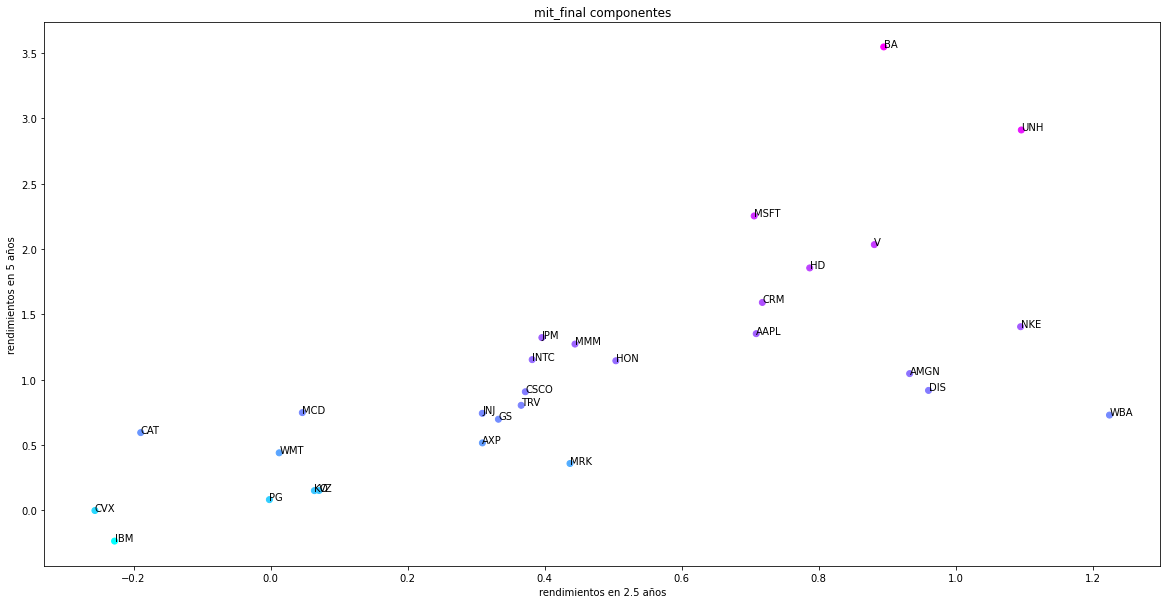

In [44]:
plt.figure(figsize=(20,10))
plt.scatter(mit_final.T.iloc[:,0], mit_final.T.iloc[:,1], c=mit_final.iloc[-1].T.apply(np.log1p), cmap='cool')
for c in mit_final.columns:
    plt.text(x=mit_final[c].iloc[0], y=mit_final[c].iloc[1], s=c)
plt.xlabel('rendimientos en 2.5 años')
plt.ylabel('rendimientos en 5 años')
plt.title('mit_final componentes');

#### Clustering de estos datos

In [45]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(mit_final.T);

clusters = {}
for l in np.unique(kmeans.labels_):
    clusters[l] = []

for i,l in enumerate(kmeans.predict(mit_final.T)):
    clusters[l].append(mit_final.columns[i])
    
for c in clusters:
    print('Cluster ' + str(c) + ': ', end='')
    for symbol in clusters[c]:
        print(get_name(symbol) + ' (' + symbol + ')', end=' ### ')
    print()
    print()

Cluster 0: Apple Inc. (AAPL) ### Amgen Inc. (AMGN) ### The Walt Disney Company (DIS) ### Nike (NKE) ### Walgreens Boots Alliance (WBA) ### 

Cluster 1: American Express Co (AXP) ### Caterpillar Inc. (CAT) ### Chevron Corp. (CVX) ### International Business Machines (IBM) ### Coca-Cola Company (The) (KO) ### Merck & Co. (MRK) ### Procter & Gamble (PG) ### Verizon Communications (VZ) ### Wal-Mart Stores (WMT) ### 

Cluster 2: Boeing Company (BA) ### United Health Group Inc. (UNH) ### 

Cluster 3: Salesforce.com (CRM) ### Home Depot (HD) ### Microsoft Corp. (MSFT) ### Visa Inc. (V) ### 

Cluster 4: Cisco Systems (CSCO) ### Goldman Sachs Group (GS) ### Honeywell Int'l Inc. (HON) ### Intel Corp. (INTC) ### Johnson & Johnson (JNJ) ### JPMorgan Chase & Co. (JPM) ### McDonald's Corp. (MCD) ### 3M Company (MMM) ### The Travelers Companies Inc. (TRV) ### 



#### Graficar los clusters

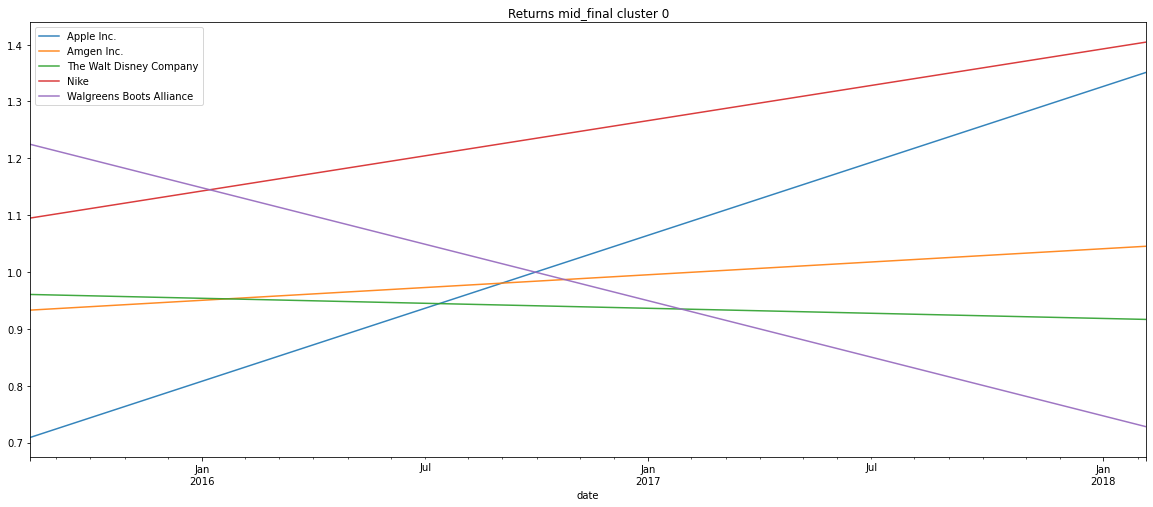

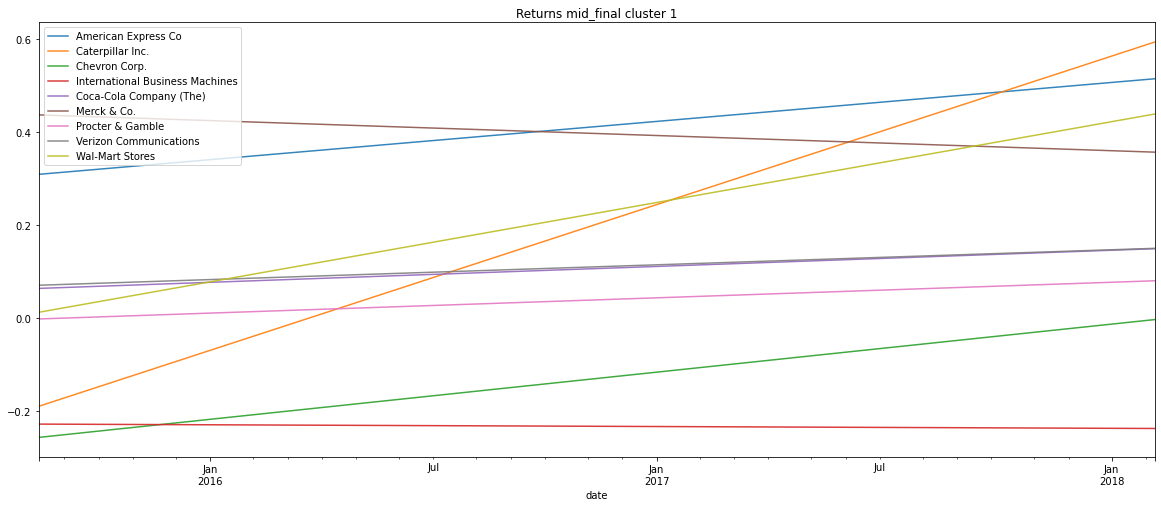

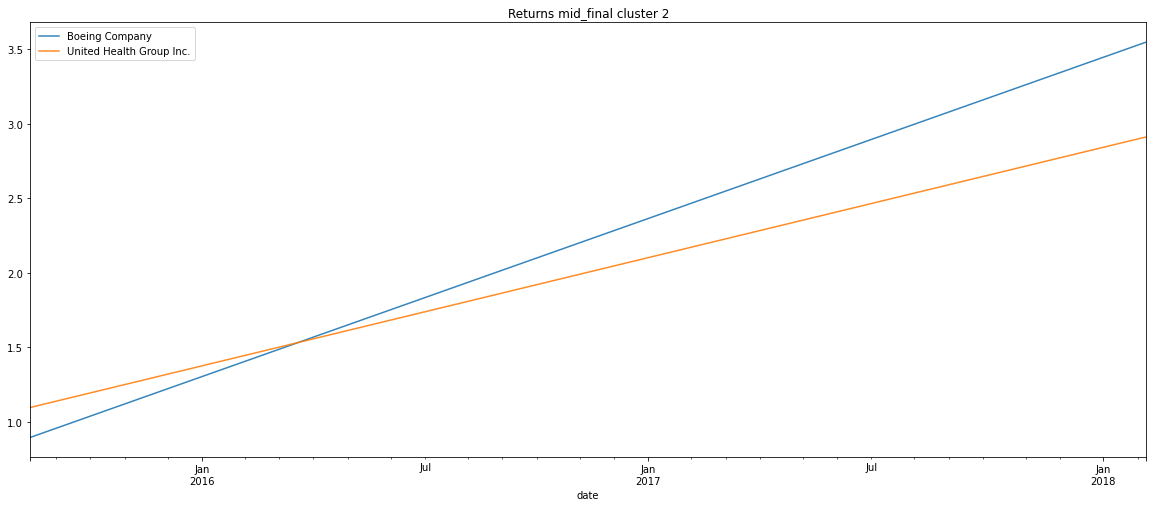

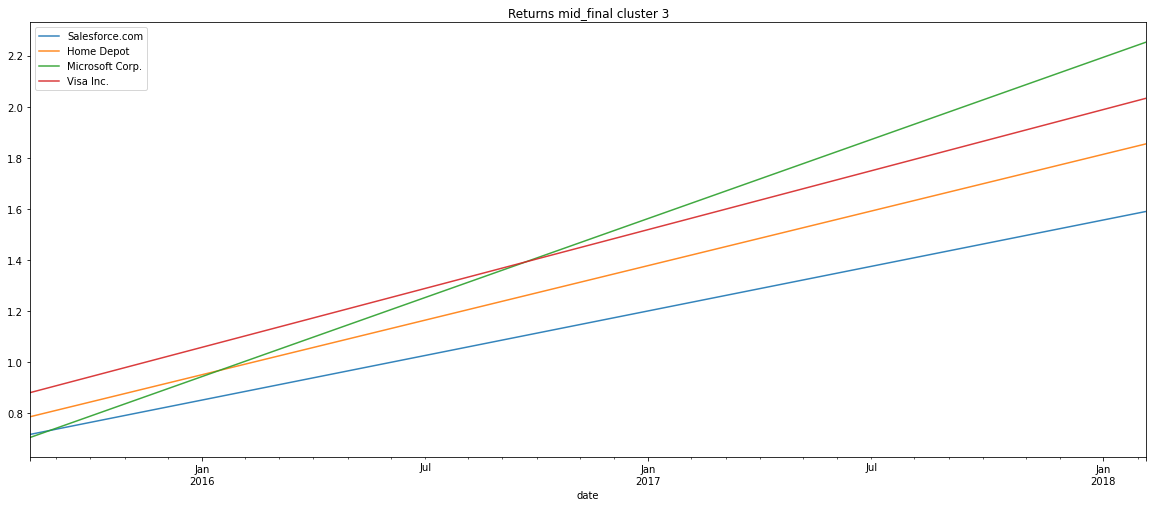

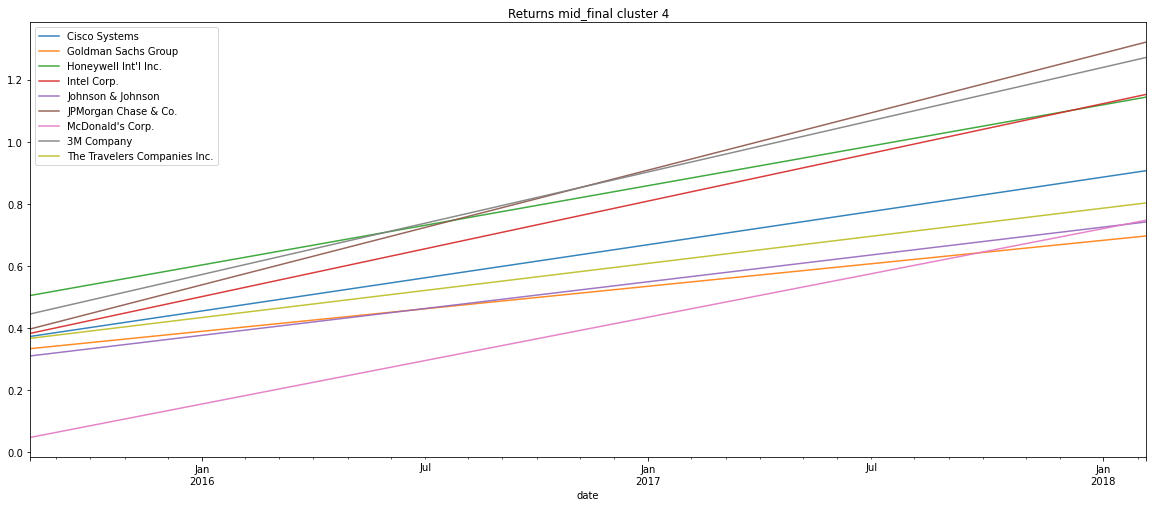

In [46]:
for c in clusters:
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=mit_final)
    plt.title('Returns mid_final cluster ' + str(c))
    plt.legend()
    plt.show()

#### Graficar los cluster con la representación de mid-final vs. Graficar rendimientos originales del Dow Jones

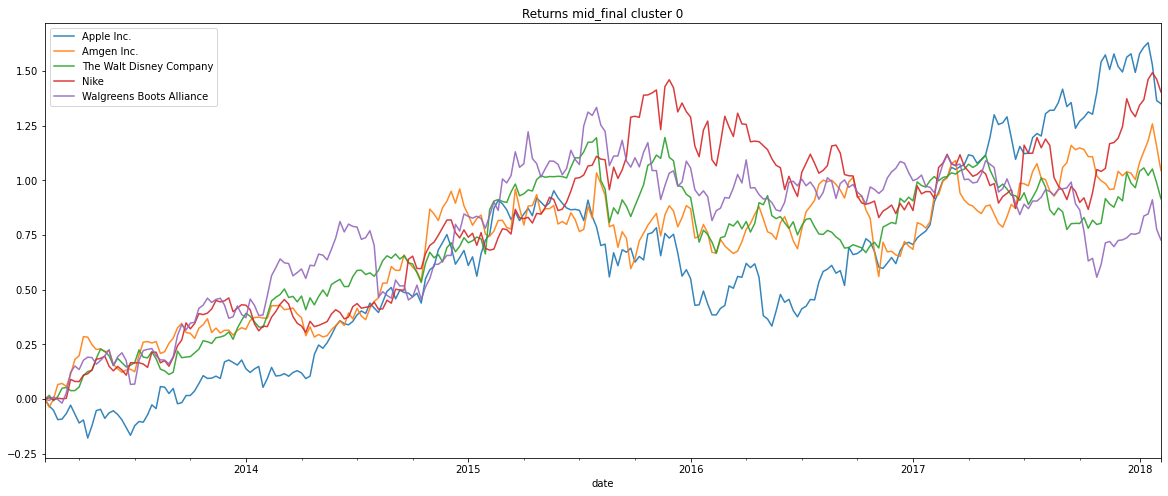

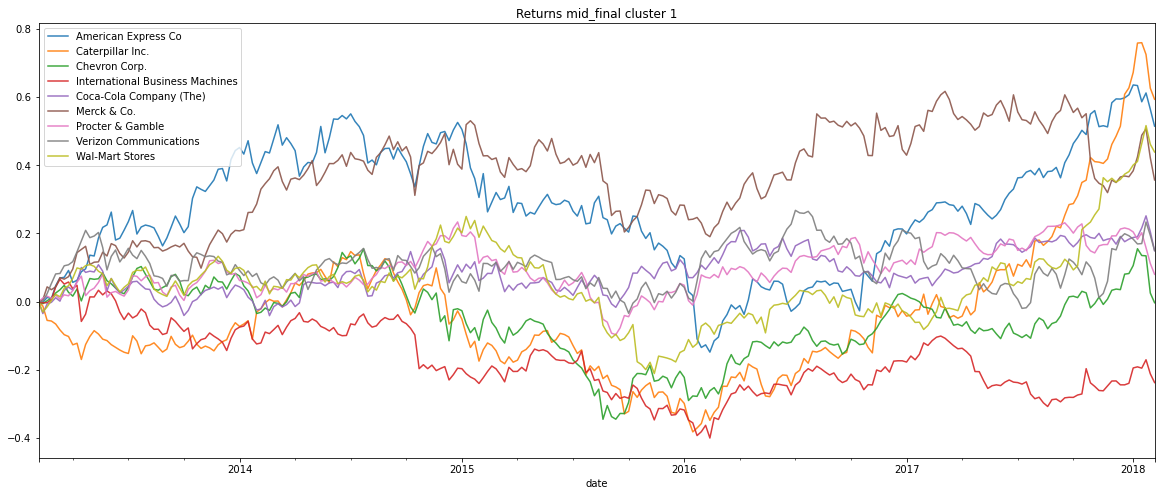

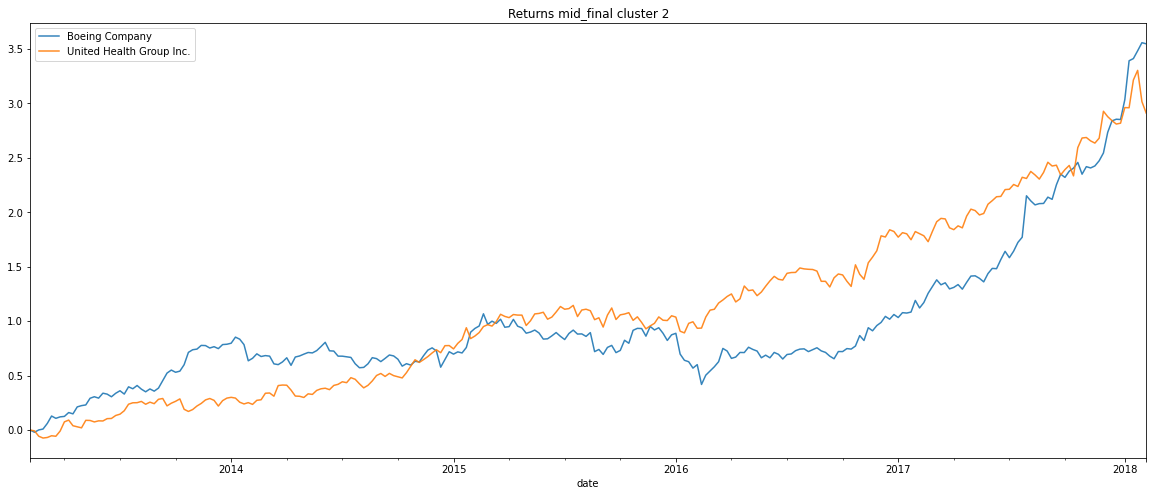

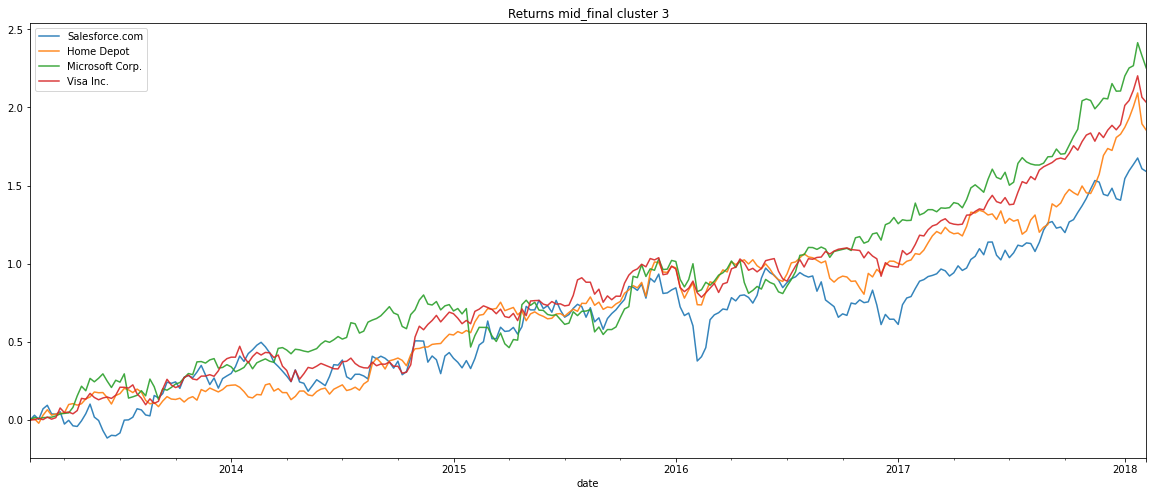

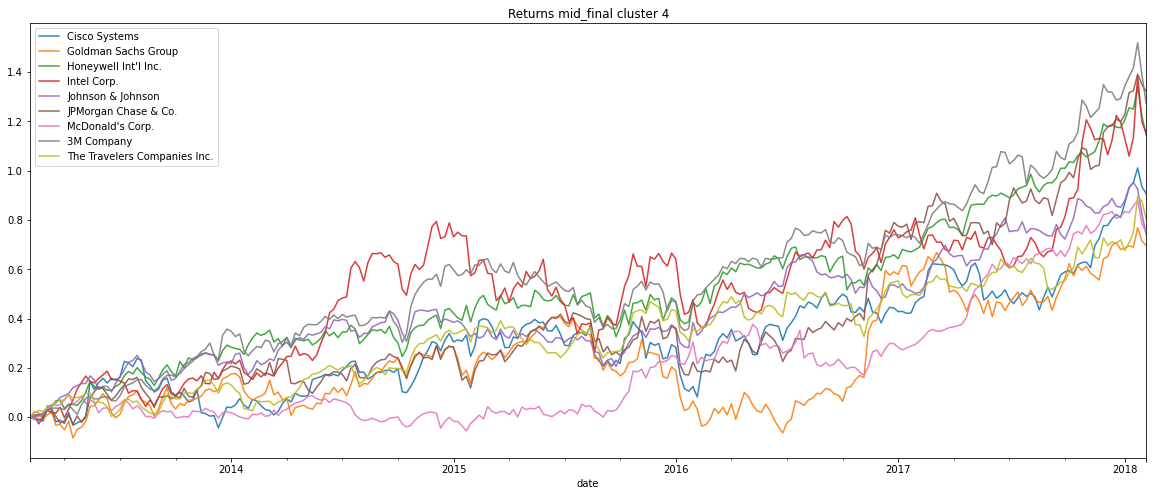

In [47]:
for c in clusters:
    plt.figure(figsize = (20,8))
    for symbol in clusters[c]:
        plot_stock(symbol, stocks=dow_rendimientos)
    plt.title('Returns mid_final cluster ' + str(c))
    plt.legend()
    plt.show()

## Otro ejemplo

In [54]:
#pip install yfinance

In [55]:
#Librerias
import yfinance as yf
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [56]:
#Cargar datos - precios de Amazon
data=yf.download('AMZN',start='2019-12-01', interval='1h',  end='2021-01-07',progress=False)[['Close']]
data.head() 

Close
2019-12-02 09:30:00-05:00  1775.150024
2019-12-02 10:30:00-05:00  1771.349976
2019-12-02 11:30:00-05:00  1770.640015
2019-12-02 12:30:00-05:00  1775.778076
2019-12-02 13:30:00-05:00  1780.439941

In [57]:
data.shape

(1929, 1)

<AxesSubplot:>

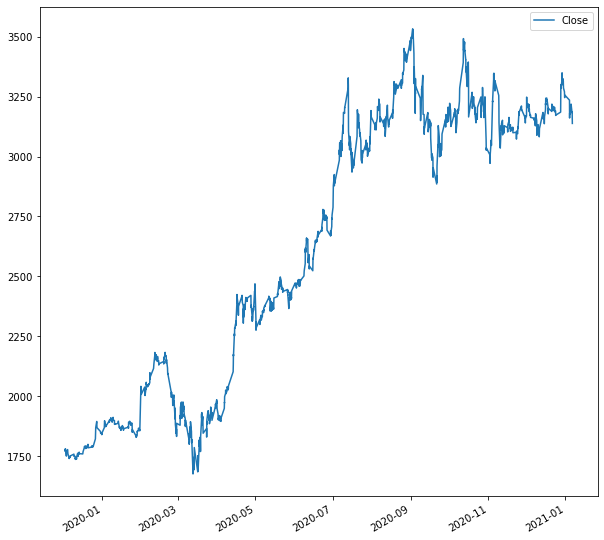

In [58]:
data.plot(figsize=(10,10))

#### Preparar los datos

Nuestros datos de entremaniento tendrán como variables un vistazo a datos pasados (rezagos) denotados como 'lb'. Par este ejemplo, vamos a usar lb=10. 

Noten que los datos de entrenamiento se escalaron usando MinMaxScaler(). 

Para este ejemplo vamos a usar 90% de datos de entrenamiento y 10% de datos de prueba. 


In [59]:
#Convertir precios a float
cl = data.Close.astype('float32')
train = cl[0:int(len(cl)*0.80)]

#escalar los datos
scl = MinMaxScaler()
scl.fit(train.values.reshape(-1,1))
cl =scl.transform(cl.values.reshape(-1,1))

#Crear una funcion para procesar los datos en observaciones de rezagos para ver los datos pasados en pedacitos
#y crear un train test dataset (90-10)
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)
 
lb=10
X,y = processData(cl,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

1726 10
192 10
1726
192


#### Crear el modelo LSTM

La predicción de las series de tiempo es un problema difícil de modelar. 
A diferencia de los problemas de regresión, las series de tiempo añaden la complejidad de que las variables son dependientes unas de las otras en el tiempo. 

El modelo LSTM es un modelo de red neuronal, llamado Long Short Term Memory. 

Este modelo es bastante poderoso para manejar datos secuenciales dependientes. Este tipo de redes neuronales es usada mucho en el área de deep learning ya que ayuda a entrenar grandes arquitecturas de datos complejas. 

In [60]:
#Crear modelo
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
 
#Cambiar la forma de los datos
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
 
#Ajustar el modelo
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)
 
model.summary() 

Epoch 1/300
54/54 [==============================] - 5s 43ms/step - loss: 0.0033 - val_loss: 0.0026
Epoch 2/300
54/54 [==============================] - 2s 33ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 3/300
54/54 [==============================] - 2s 34ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 4/300
54/54 [==============================] - 3s 47ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 5/300
54/54 [==============================] - 2s 38ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 6/300
54/54 [==============================] - 2s 37ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 7/300
54/54 [==============================] - 2s 35ms/step - loss: 8.9072e-04 - val_loss: 0.0016
Epoch 8/300
54/54 [==============================] - 2s 36ms/step - loss: 8.1290e-04 - val_loss: 0.0016
Epoch 9/300
54/54 [==============================] - 2s 36ms/step - loss: 7.7499e-04 - val_loss: 0.0017
Epoch 10/300
54/54 [==============================] - 2s 35ms/step - loss: 7.7467e-04 - 

Epoch 152/300
54/54 [==============================] - 2s 35ms/step - loss: 2.4253e-04 - val_loss: 6.7615e-05
Epoch 153/300
54/54 [==============================] - 2s 35ms/step - loss: 2.2945e-04 - val_loss: 6.6828e-05
Epoch 154/300
54/54 [==============================] - 2s 35ms/step - loss: 2.2669e-04 - val_loss: 6.6984e-05
Epoch 155/300
54/54 [==============================] - 2s 35ms/step - loss: 2.1300e-04 - val_loss: 6.7397e-05
Epoch 156/300
54/54 [==============================] - 2s 42ms/step - loss: 2.0817e-04 - val_loss: 6.8294e-05
Epoch 157/300
54/54 [==============================] - 2s 45ms/step - loss: 2.0141e-04 - val_loss: 6.9463e-05
Epoch 158/300
54/54 [==============================] - 2s 40ms/step - loss: 1.9971e-04 - val_loss: 7.0312e-05
Epoch 159/300
54/54 [==============================] - 2s 34ms/step - loss: 1.9933e-04 - val_loss: 7.0968e-05
Epoch 160/300
54/54 [==============================] - 2s 34ms/step - loss: 2.0119e-04 - val_loss: 7.1463e-05
Epoch 161/

54/54 [==============================] - 2s 43ms/step - loss: 2.0044e-04 - val_loss: 7.0109e-05
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


Text(0.5, 1.0, 'Datos de entrenamiento')

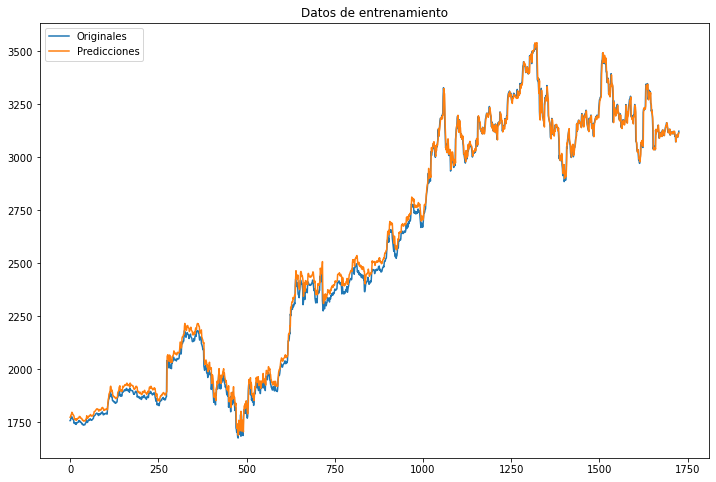

In [61]:
#Predicciones en el train dataset

plt.figure(figsize=(12,8))
 
Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Originales")
plt.plot(scl.inverse_transform(Xt), label="Predicciones")
plt.legend()
plt.title("Datos de entrenamiento")

Text(0.5, 1.0, 'Test Dataset')

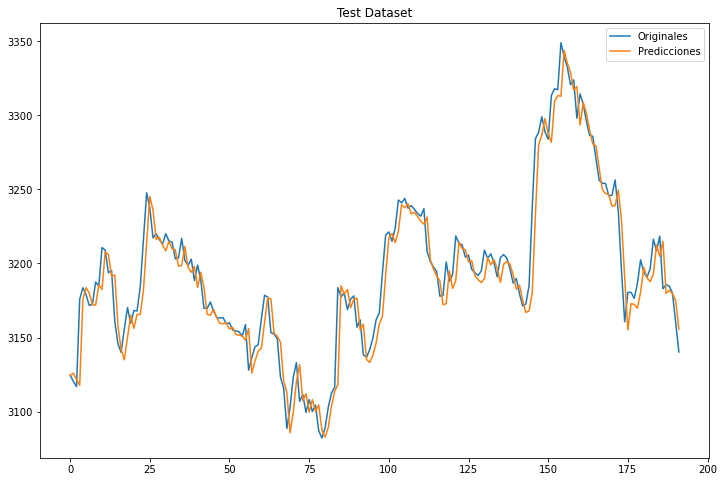

In [62]:
# en el test
plt.figure(figsize=(12,8))
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Originales")
plt.plot(scl.inverse_transform(Xt), label="Predicciones")
plt.legend()
plt.title("Test Dataset")

El modelo parece funcionar perfectamente en el conjunto de datos de entrenamiento y muy bien en el conjunto de datos de prueba. Sin embargo, debemos enfatizar que el modelo predice una sola observación más adelante. 

Lo que significa que para cada nueva observación que tiene que predecir, toma como entrada las 10 observaciones anteriores. En la vida real, esto es un poco inútil, ya que principalmente queremos predecir muchas observaciones en el futuro. Veamos cómo podemos hacerlo en Python.

**Predecir N pasos por delante**

La lógica aquí es agregar los nuevos valores predichos como características en la entrada del modelo para que podamos predecir N pasos adelante. En nuestro caso, predeciremos con anticipación 251 observaciones, tantas como las observaciones del conjunto de datos de prueba.


Text(0.5, 1.0, 'Datos de test para 250 observaciones futuras')

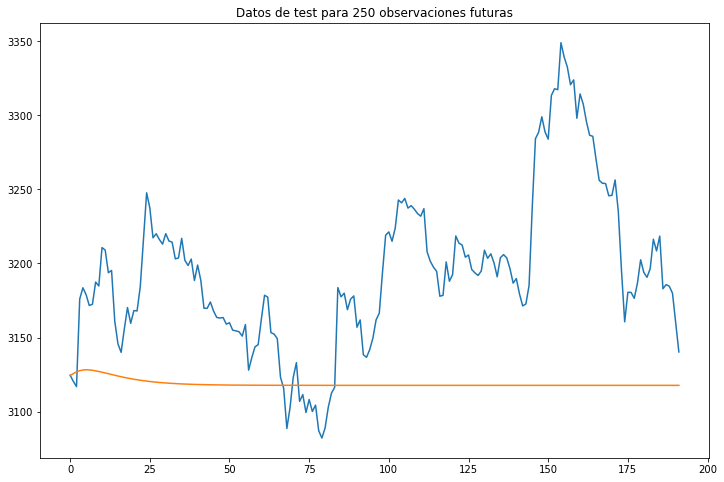

In [50]:
def processData(data,lb):
    X= []
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
    return np.array(X)
 
# crear el x_test dummy
cl2 =cl.copy()
pred = []
for i in range(X_test.shape[0]): #251
    cl2[int(X.shape[0]*0.90)+i+lb] = model.predict(X_test)[i]
    pred.extend(model.predict(X_test)[i])
    X = processData(cl2,lb)
    X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
 
prediction = scl.inverse_transform(np.array(pred).reshape(-1, 1))
plt.figure(figsize=(12,8))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)),  label="Original")
plt.plot(prediction, label="Predicciones")
 
plt.title("Datos de test para 250 observaciones futuras")

**Conclusión**
Aunque el modelo funcionó muy bien para predecir una observación más adelante, cuando intentamos predecir N observaciones más adelante, fue un fracaso.

Esto tiene sentido porque “multiplicamos el error” ya que nuestras características son valores predichos que incluyen un error. Además, ningún modelo podrá predecir el futuro de n observaciones en el futuro.

Demostramos anteriormente que el modelo no pudo predecir N pasos por delante. Esto se debe a que no existe un patrón en los precios de las acciones. Veamos cómo funcionan los modelos LSTM con series periódicas como el coseno



Epoch 1/300
85/85 [==============================] - 2s 22ms/step - loss: 0.0244 - val_loss: 0.0062
Epoch 2/300
85/85 [==============================] - 1s 18ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 3/300
85/85 [==============================] - 2s 18ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 4/300
85/85 [==============================] - 2s 18ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 5/300
85/85 [==============================] - 2s 22ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 6/300
85/85 [==============================] - 2s 22ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 7/300
85/85 [==============================] - 2s 20ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 8/300
85/85 [==============================] - 2s 19ms/step - loss: 0.0015 - val_loss: 8.7592e-04
Epoch 9/300
85/85 [==============================] - 2s 20ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 10/300
85/85 [==============================] - 2s 19ms/step - loss: 0.0022 - val_loss: 9.

Epoch 151/300
85/85 [==============================] - 2s 20ms/step - loss: 5.3529e-05 - val_loss: 3.2466e-07
Epoch 152/300
85/85 [==============================] - 2s 18ms/step - loss: 3.5390e-07 - val_loss: 1.3531e-07
Epoch 153/300
85/85 [==============================] - 2s 18ms/step - loss: 7.5980e-07 - val_loss: 3.9537e-07
Epoch 154/300
85/85 [==============================] - 2s 18ms/step - loss: 1.1258e-05 - val_loss: 3.7233e-06
Epoch 155/300
85/85 [==============================] - 2s 19ms/step - loss: 3.9754e-05 - val_loss: 1.3492e-071e-0
Epoch 156/300
85/85 [==============================] - 2s 19ms/step - loss: 4.6148e-06 - val_loss: 2.8934e-05
Epoch 157/300
85/85 [==============================] - 2s 19ms/step - loss: 5.9376e-05 - val_loss: 6.5834e-07
Epoch 158/300
85/85 [==============================] - 2s 19ms/step - loss: 7.0383e-07 - val_loss: 1.1285e-07
Epoch 159/300
85/85 [==============================] - 2s 18ms/step - loss: 1.5797e-07 - val_loss: 1.0858e-07
Epoch 

85/85 [==============================] - 2s 20ms/step - loss: 2.6370e-05 - val_loss: 4.4313e-07
Epoch 300/300
85/85 [==============================] - 2s 19ms/step - loss: 5.3464e-07 - val_loss: 2.1762e-08


Text(0.5, 1.0, 'Train Dataset')

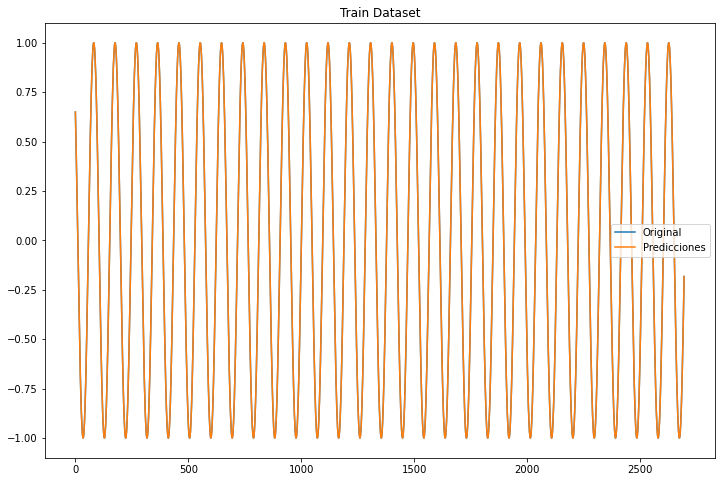

In [51]:
from keras.models import Sequential
from keras.layers import LSTM,Dense, Dropout, BatchNormalization
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
 
from sklearn.preprocessing import MinMaxScaler
 
#crear datos con patrón de coseno
cl = np.linspace(-100, 100, 3000)
cl = np.cos(cl)
train = cl[0:int(len(cl)*0.90)]
scl = MinMaxScaler()
#escalar los datos
scl.fit(train.reshape(-1,1))
cl =scl.transform(cl.reshape(-1,1))

def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)
 
 
lb=5
X,y = processData(cl,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
 
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
 
 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
 
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)
 
 
plt.figure(figsize=(12,8))
 
Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(y_train.reshape(-1,1)), label="Original")
plt.plot(scl.inverse_transform(Xt), label="Predicciones")
plt.legend()
plt.title("Train Dataset")

Text(0.5, 1.0, 'Test Dataset')

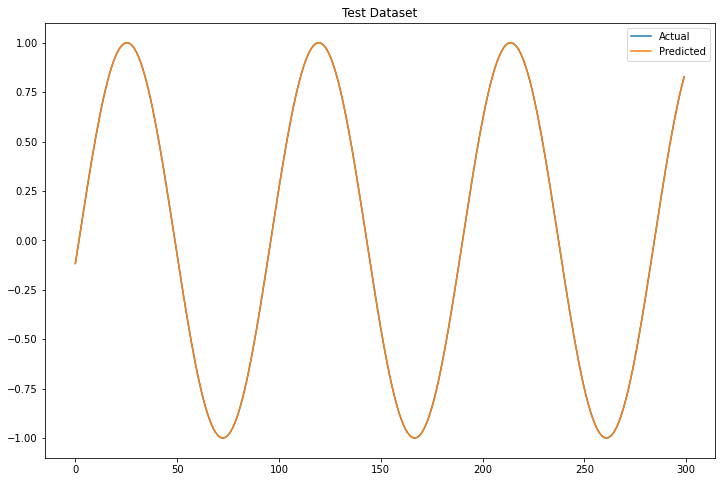

In [52]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Test Dataset")

Text(0.5, 1.0, 'Test Dataset 300 Obs por adelante')

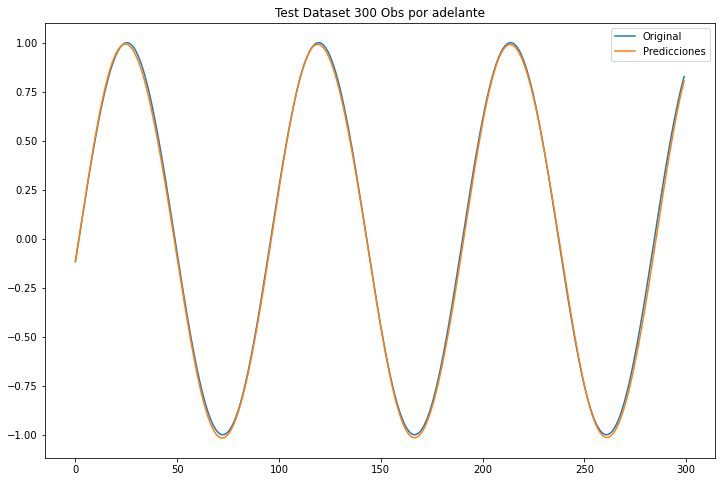

In [53]:
def processData(data,lb):
    X= []
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
    return np.array(X)
 
# crear el xtest dummy
cl2 =cl.copy()
pred = []
for i in range(X_test.shape[0]):
    cl2[int(X.shape[0]*0.90)+i+lb] = model.predict(X_test)[i]
    pred.extend(model.predict(X_test)[i])
    X = processData(cl2,lb)
    X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
 
 
Xt = model.predict(X_test)
plt.figure(figsize=(12,8))
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Original")
plt.plot(scl.inverse_transform(Xt), label="Predicciones")
plt.legend()
plt.title("Test Dataset 300 Obs por adelante")